# Data Processing Tutorial

In this tutorial, we will process some raw data from an MQF experiment.

## 1. Import Libraries
This includes `pandas` for generating neat tables, `numpy` for its mathematical functions, `matplotlib` for visualizing spectra, and `nmrglue` for importing raw NMR data.

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import nmrglue as ng
import glob

## 2. Load the NMR data
* The first line of the cell loads all NMR data in the "tutorial_data" folder that contains "MQF" in its filename.
* Each experiment loaded is a collection of FIDs.
* The output of the cell gives information about the the data. For each experiment, the number of FIDs loaded as well as features of those FIDs are displayed. In this case, both experiments consist of four FIDs. These FIDs are made up of 262,144 complex points collected in 32 transients with a delay time of 30 seconds between scans.

In [2]:
filenames = glob.glob("tutorial_data/*MQF*.fid")
experiment_list = []
for filename in filenames:
    dic, FIDs = ng.varian.read(filename)
    count = 0
    for i in range(np.shape(FIDs)[0]):
        # ignore blank data
        thisFID = FIDs[i]
        if np.sum(thisFID) == 0.0 or np.max(np.abs(thisFID)) < 0.1:
            print "Ignored blank FID %d from %s." % (i+1, filename)
            continue
        count += 1
        experiment_list.append(FIDs[i])    
    npoints = np.shape(experiment_list[0])[0]
    print "Sequence: %s (%s=%s, %s=%s)" % (dic["procpar"]["seqfil"]["values"][0], dic["procpar"]["dn"]["values"][0],
                                           dic["procpar"]["dm"]["values"][0], dic["procpar"]["dn2"]["values"][0],
                                           dic["procpar"]["dm2"]["values"][0])
    print "%d FIDs loaded from %s (%d complex points, nt=%sx%s, d1=%s s)." % (count, filename, npoints, len(dic["procpar"]["nt"]["values"]), dic["procpar"]["nt"]["values"][0], dic["procpar"]["d1"]["values"][0])

Sequence: MQF1DF (C13=nnn, H1=nyy)
4 FIDs loaded from tutorial_data/tutorial_MQF_2.fid (262144 complex points, nt=4x32, d1=30 s).
Sequence: MQF1DF (C13=nnn, H1=nyy)
4 FIDs loaded from tutorial_data/tutorial_MQF_1.fid (262144 complex points, nt=4x32, d1=30 s).


## 3. Load Spectral Parameters

We load the spectrometer frequency in MHz (`obs`), the sweep width in Hz (`sw`), and transmitter offset in Hz (`tof`) from the parameter file.  Notice that we only define these once because they're the same for all of the loaded spectra. In the second part of the cell we create a universal dictionary of spectral parameters using `nmrglue`.  You should not need to change the values here.

In [3]:
obs = float(dic["procpar"]["reffrq"]["values"][0])
sw  = float(dic["procpar"]["sw"]["values"][0])  
tof = float(dic["procpar"]["tof"]["values"][0])     
carrier = obs*1.0E6 + tof                           # carrier frequency in Hz

udic = ng.varian.guess_udic(dic, FIDs)  
udic[0]['size']     = int(dic["np"])   # number of R|I points in the spectrum
udic[0]['complex']  = True             # True if complex data
udic[0]['encoding'] = 'direct'         # keep as 'direct'
udic[0]['sw']       = sw               # spectral width in Hz
udic[0]['obs']      = obs              # Observation freq. in MHz.
udic[0]['car']      = carrier          # carrier freq in Hz
udic[0]['label']    = 'F19'            # the observed nucleus
udic[0]['time']     = True             # whether this is time domain data
udic[0]['freq']     = False
udic["ndim"]=1

## 4. FID Processing

Here we define a function (`process`) that puts our NMR data into a python processing-friendly format. Specifically, this function loads in a parameter dictionary and an FID and converts it from the NMR machine format (Varian/Agilent) to NMRpipe format. There are some important features of the `process` function. The first step is exponential apodization (`pipe_proc.em`) with line broadening (`lb`). The line broadening constant can be tuned as desired. The next steps are zero-filling (`pip_proc.zf`) and applying the fourier transform (`pipe_proc.ft`). The final step is phase correction (`pipe_proc.ps`). Correcting the phase is essential for accurate processing. We will return to this in the next cell.

See the tutorial for more details.

In [4]:
def process(dic, FID):
    C = ng.convert.converter()
    C.from_varian(dic, FID, udic)
    pdic, pdata = C.to_pipe()
    pdic, pdata = ng.pipe_proc.em(pdic, pdata, lb=0.25)                 # line broadening
    pdic, pdata = ng.pipe_proc.zf(pdic, pdata, size=4*npoints, auto=True)
    pdic, pdata = ng.pipe_proc.ft(pdic, pdata)
    pdic, pdata = ng.pipe_proc.ps(pdic, pdata, p0=202, p1=0)            # phase correction
    return pdic, pdata

## 5. Produce a Processed, Referenced, and Phased Spectrum

* Apply the processing function to each FID loaded in the second block of code.
* Set the horizontal axis to ppm scale.
* Adjust the reference for the chemical shift scale by changing the constant (-239.525 right now).
* Plot one of the processed spectra.

If this is the first time you're loading new data, your spectrum likely will be incorrectly phased. To adjust this return to the block above and modify the phase correction parameters: `p0` (zero order phase correction) and `p1` (first order phase correction). In general, if peaks are too high on the right, the phase correction constants must be increased. If the right sides of the leftmost peaks are lower than the right side of the rightmost peaks, the first order phase correction should be increased. Ideally, peaks will be symmetric and Lorentzian in shape. Because of the nature of the MQF pulse sequence, it may be impossible to phase all peaks perfectly with just these two phases. However, don't worry; there are opportunities for individual peak phasing below.

You may want to try changing `plt.xlim` to zoom in for a better look.

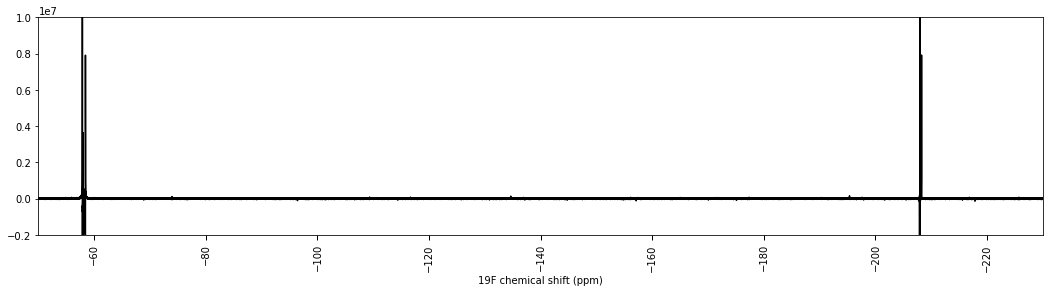

In [5]:
raw_spectrum_list = [ process(dic,FID) for FID in experiment_list ]
raw_spectra = [ spectrum for dic, spectrum in raw_spectrum_list ]
    
pdic, pdata = raw_spectrum_list[1]
uc = ng.pipe.make_uc(pdic, pdata)
ppm = uc.ppm_scale()
ppm = ppm - ppm[-1] - 239.525        # adjust this to alter the peak referencing
  
spectrum_number = 0       # this line allows you to choose which FID to view (zero-indexed)
spectrum = raw_spectra[spectrum_number]
plt.figure(figsize=(18,4))
plt.plot(ppm, np.real(spectrum), "k")
plt.xlim(-50,-230)      # adjust this to move along the ppm axis
plt.ylim(-2E6,1E7)      # adjust this to change the vertical scale

plt.xlabel("19F chemical shift (ppm)")
ax = plt.gca()
ax.tick_params(top="off")
ax.get_xaxis().set_tick_params(length=5,direction='out', width=1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

## 6. Define Peaks and Adjust Phases

* Define the peak integration regions below.
* If a peak requires more phase adjustment, change the corresponding value in the `phases` list.
* In the case of MQF, it is also useful to define the region where the residual <sup>12</sup>C-<sup>19</sup>F appears. As a result, three regions should be chosen for each fluorine in the molecule: two satelite-containing regions and one residual parent peak region.

In [6]:
interval = ppm[1]-ppm[0]
def find_index(this_ppm):
    return int(np.ceil((this_ppm-ppm[0])/interval))

def cphase(angle):
    return np.exp(1j*np.radians(angle))

# define all peaks in ppm and pick their phase corrections
peaks = [(-57.86,-57.89), (-57.97,-58.3), (-58.40,-58.44), (-207.875,-207.92), (-207.94,-208.05), (-208.2375,-208.2775) ]
phases = [-65.0,             -65.0,            114.5,             180.0,                0.0,               0.0]

cphases = [ cphase(i) for i in phases ]

## 7. Check the Peak Intervals and Phasing
At this point the spectrum is almost ready for integration. In this block, we can check each peak individually and see if the region of integration should be shifted or if the phase correction needs to be modified. In fact, it is a good idea to use the cell blow and the cell above to adjust peak regions and phases until they are as close to perfect as possible. This will ensure the most accurate and reliable integrals.

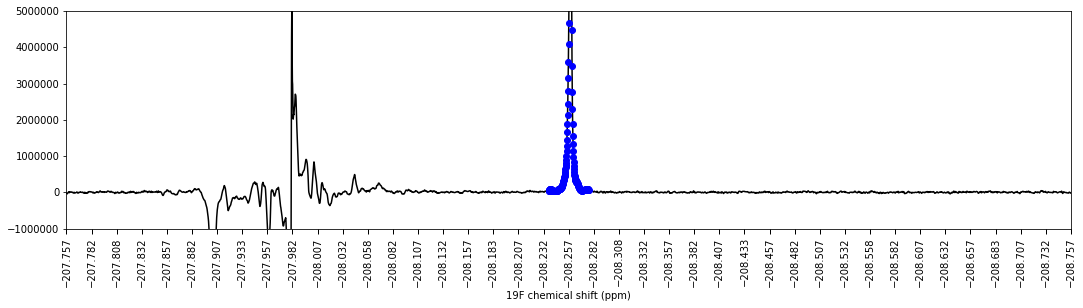

In [7]:
spectrum_number = 1      # choose which spectrum to look at (zero-indexed)
peak_number = 5          # choose which peak to look at (zero-indexed)
spectrum = raw_spectra[spectrum_number]

plt.figure(figsize=(18,4))
peak = peaks[peak_number]
phase = cphases[peak_number]

plt.plot(ppm, np.real(spectrum*phase), "k")

center = np.average(peak)
x_axis_range = 0.5
start = center+x_axis_range
end = center-x_axis_range
plt.xlim(start,end)
plt.ylim(-1E6, 5E6)      # adjut the vertical axis if necessary

peak_start = find_index(peak[0])
peak_end = find_index(peak[1])
peak_x = ppm[peak_start:peak_end]
peak_y = np.real(spectrum[peak_start:peak_end]*phase)
plt.plot(peak_x,peak_y,"bo")

plt.xlabel("19F chemical shift (ppm)")
plt.xticks(np.linspace(end,start,41))

ax = plt.gca()
ax.tick_params(top="off")
ax.get_xaxis().set_tick_params(length=5,direction='out', width=1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show()

## 8. Computing and Applying a Baseline Correction

In the final step of NMR pre-processing, we calculate and apply an n<sup>th</sup> order baseline correction to each spectrum. The function works by first defining all parts of the spectrum that are not peaks as "noise". It next fits a polynomial to this noise and then subtracts it from the raw-spectrum. The order of the function can be adjusted based on the needs of the user. The `clip_below` and `clip_above` parameters in the function definition specify the vertical region outside of which noise will be ignored. Finally, the plot boolean can be set to `True` if the user would like to see the baseline overlayed on each spectrum. The output of the function is either a plotted spectrum or a numerical summary of the baseline correction (the polynomial coefficients and RMSE).

In [8]:
def compute_baseline(spectrum, order=2, clip_below = -60000, clip_above = 60000, plot=False):
    noise_x = ppm.copy()
    noise_y = np.real(spectrum.copy())
    mask = np.ones(len(ppm), dtype=bool)
    for peak in peaks:
        index_low  = find_index(peak[0])
        index_high = find_index(peak[1])
        mask[index_low:index_high] = False
    noise_x = noise_x[mask]
    noise_y = noise_y[mask]
    noise_y = np.clip(noise_y, clip_below, clip_above)

    poly_coeff = np.polyfit(noise_x,noise_y,order)
    baseline_func = np.poly1d(poly_coeff)
    baseline = baseline_func(ppm)
    RMSE = np.sqrt(np.mean(np.square(noise_y-baseline_func(noise_x))))

    if plot:
        plt.figure(figsize=(18,4))
        plt.plot(ppm, np.real(spectrum), "k")
        plt.plot(ppm, baseline, "r")
        y_minus_limit = 1.67*clip_below if clip_below < 0.0 else 0.6*clip_below
        y_plus_limit = 1.67*clip_above if clip_above > 0.0 else 0.6*clip_above
        plt.ylim(y_minus_limit,y_plus_limit)
        plt.xlabel("19F chemical shift (ppm)")
        ax = plt.gca()
        ax.tick_params(top="off")
        ax.get_xaxis().set_tick_params(length=5,direction='out', width=1)
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)
        plt.show()
    else:
        print "%.1E " % (RMSE / 1E5),
        for i in poly_coeff:
            print "%6.2f" % i,
        print
    return baseline

baselines = [ compute_baseline(spectrum) for spectrum in raw_spectra ]
subtracted_spectra = [ spectrum - baseline for spectrum, baseline in zip(raw_spectra,baselines) ]

1.3E-01   -0.06   4.04 3556.09
1.3E-01    0.17  41.43 1417.14
1.3E-01    0.19  44.26 952.91
1.3E-01    0.04  18.38 2003.95
1.4E-01   -0.27 -33.80 4239.83
1.3E-01    0.14  35.34 1569.38
1.3E-01    0.14  35.22 1036.78
1.3E-01    0.11  30.70 1852.44


## 9. Calculate the Signal to Noise Ratios

With the NMR spectra fully processed, we can now obtain relevant information from the data. The first useful statistic is the signal to noise (S/N) ratio. The `compute_signal_to_noise` function takes in a spectrum and a user-defined region of noise to calculate S/N. The noise range should be defined carefully to be relatively uniform and completely peak free. The function itself applies a zero-order correction to the noise region before calculating the RMS of the noise level in the defined region. To calculate the S/N it divides half of the max signal of a given peak by this RMS noise level. The function returns the signal to noise ratio for each peak by averaging the calculated ratios for every spectrum analyzed.

In [9]:
def compute_signal_to_noise(spectrum, noise=(-95.00, -100.00), plot=False):
    xy = np.array([ppm,spectrum])
    min_value2 = find_index(noise[0])
    max_value2 = find_index(noise[1])
    y_noise  = np.real(xy[1,min_value2:max_value2])
    zero_level   = np.mean(y_noise)

    signal_to_noise = []
    for i,peak in enumerate(peaks):
        min_value1 = find_index(peak[0])
        max_value1 = find_index(peak[1])
        y_signal = np.real(xy[1,min_value1:max_value1]*cphases[i])

        signal_level = np.max(y_signal - zero_level)/2.0
        noise_level  = np.sqrt(np.mean(np.square(y_noise-zero_level))) 
        signal_to_noise.append(signal_level / noise_level)
        
        if plot:
            print "%.2E %.2E" % (signal_level, noise_level)
            print zero_level
            plt.plot(x_signal,y_signal,"r")
            plt.plot(x_noise,y_noise,"b")
            #plt.ylim(-5E4,5E4)
            plt.show()

    return signal_to_noise

signal_to_noise_list = [ compute_signal_to_noise(spectrum) for spectrum in subtracted_spectra ]
signal_to_noise = DataFrame(signal_to_noise_list)
experiment_numbers = [ i+1 for i in range(len(raw_spectra)) ]
signal_to_noise["run"] = experiment_numbers
signal_to_noise.set_index("run",drop=True,inplace=True)
peak_numbers = range(len(peaks))
peak_numbers = ["peak %d" % (i+1) for i in peak_numbers]
signal_to_noise.columns = peak_numbers
#display(signal_to_noise)

avg_signal_to_noise = signal_to_noise.mean()
avg_signal_to_noise = avg_signal_to_noise.apply(lambda x : "%.0f" % x)
avg_signal_to_noise.name = "S/N"
display(avg_signal_to_noise)

peak 1    915
peak 2    501
peak 3    890
peak 4    296
peak 5    598
peak 6    298
Name: S/N, dtype: object

## 10. Calculate the Peak Integrals
Finally, the next three boxes of code are used to calculate the average integrals and some associated statstics for each peak. The first box defines the integration function itself and the second box applies that function to each peak within each spectrum. A user can choose whether the integrals are in absolute arbitrary units or are referenced relative to another peak in the spectrum. The output from the second block of code shows the individual integrals from each peak for each experiment. Lastly, the third block of code provides the user with summary statistics: average integrals and their associated standard deviations, coefficients of variation, standard errors, standard errors of the coefficient of variation, and signal to noise ratios.

In [10]:
def integrate(spectrum, i, peak):
    index_low = find_index(peak[0])
    index_high = find_index(peak[1])
    return np.sum(np.real(spectrum[index_low:index_high]*cphases[i]))

In [11]:
# integrate all spectra
results=[]
for spectrum in subtracted_spectra:
    integrals = []
    for i,peak in enumerate(peaks):
        integrals.append(integrate(spectrum,i,peak))
    integrals = np.array(integrals)
    integrals = integrals/2E7                          # for absolute integrals (arbitrary scale factor)
    #integrals = 10.00 * integrals / integrals[3]      # for referenced integrals
    results.append(integrals)
    
integrations = DataFrame(results)

integrations.columns = peak_numbers
integrations["run"] = experiment_numbers
integrations.set_index("run",drop=True,inplace=True)

display(integrations)

,peak 1,peak 2,peak 3,peak 4,peak 5,peak 6
run,,,,,,
1,18.386262,0.533341,18.428295,8.693112,-0.193676,8.800940
2,18.019076,0.159920,18.280568,8.710253,-0.930087,8.856062
3,17.678884,0.645394,18.278564,8.789973,-0.201184,8.750826
4,18.130820,-2.669158,18.066361,9.709195,2.584680,8.724589
5,18.079298,2.870281,18.330034,7.636244,-1.800313,8.714607
6,18.437380,2.277327,18.312585,8.418888,-0.150697,8.786001
7,18.067495,-1.275134,18.128215,9.070658,1.625930,8.803467
8,17.923212,0.154697,18.133286,9.106791,0.515478,8.706342


In [12]:
print "n = %d" % len(integrations)
mean = integrations.mean().apply(lambda x : "%.4f" % x)
stdev = integrations.std().apply(lambda x : "%.4f" % x)
cov = (100.0*integrations.std()/integrations.mean()).apply(lambda x : "%.2f%%" % x)
stderr = (integrations.std() / np.sqrt(len(integrations))).apply(lambda x : "%.4f" % x)
stderr_cov = (100*integrations.std()/(integrations.mean()*np.sqrt(len(integrations)))).apply(lambda x : "%.2f%%" % x)
headings = ["avg", "stdev", "cov", "stderr", "stderr_cov", "S/N"]
summary_df = DataFrame([mean, stdev, cov, stderr, stderr_cov, avg_signal_to_noise], index=headings)
display(summary_df)

n = 8


,peak 1,peak 2,peak 3,peak 4,peak 5,peak 6
avg,18.0903,0.3371,18.2447,8.7669,0.1813,8.7679
stdev,0.2428,1.7735,0.1230,0.5981,1.3905,0.0524
cov,1.34%,526.12%,0.67%,6.82%,767.09%,0.60%
stderr,0.0858,0.6270,0.0435,0.2115,0.4916,0.0185
stderr_cov,0.47%,186.01%,0.24%,2.41%,271.21%,0.21%
S/N,915,501,890,296,598,298
